# 1. 에일리언 vs 프레데터 데이터셋
* https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images
* 케글 로그인 -> 우측 상단의 계정을 클릭 -> Your Profile -> 중앙 메뉴의 Account를 클릭 -> API 항목에 Create New API Token을 클릭 -> kaggle.json이 다운로드 됨
* kaggle.json을 메모장으로 열기


In [ ]:
import os

In [ ]:
os.environ['KAGGLE_USERNAME'] =
os.environ['KAGGLE_KEY'] =

In [ ]:
!kaggle datasets download -d pmigdal/alien-vs-predator-images

alien-vs-predator-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q alien-vs-predator-images.zip

replace alien_vs_predator_thumbnails/data/train/alien/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# 2. 이미지 증강 기법(Image Augmentataion)
* 원본 이미지(데이터)를 조작하여 원본과는 크고 작은 변화를 가진 이미지를 생성
* 일반적으로 모델 성능이 좋아짐
* 오버피팅을 방지
* https://pytorch.org/vision/master/transforms.html

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        # 각도, 찌그러뜨림, 크기
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        # 수평으로 뒤집기
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [ ]:
def target_transforms(target):
    return torch.FloatTensor([target])

In [ ]:
image_datasets = {
    'train': datasets.ImageFolder('data/train', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('data/validation', data_transforms['validation'], target_transform=target_transforms)
}

In [ ]:
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

In [ ]:
print(len(image_datasets['train']), len(image_datasets['validation']))

694 200


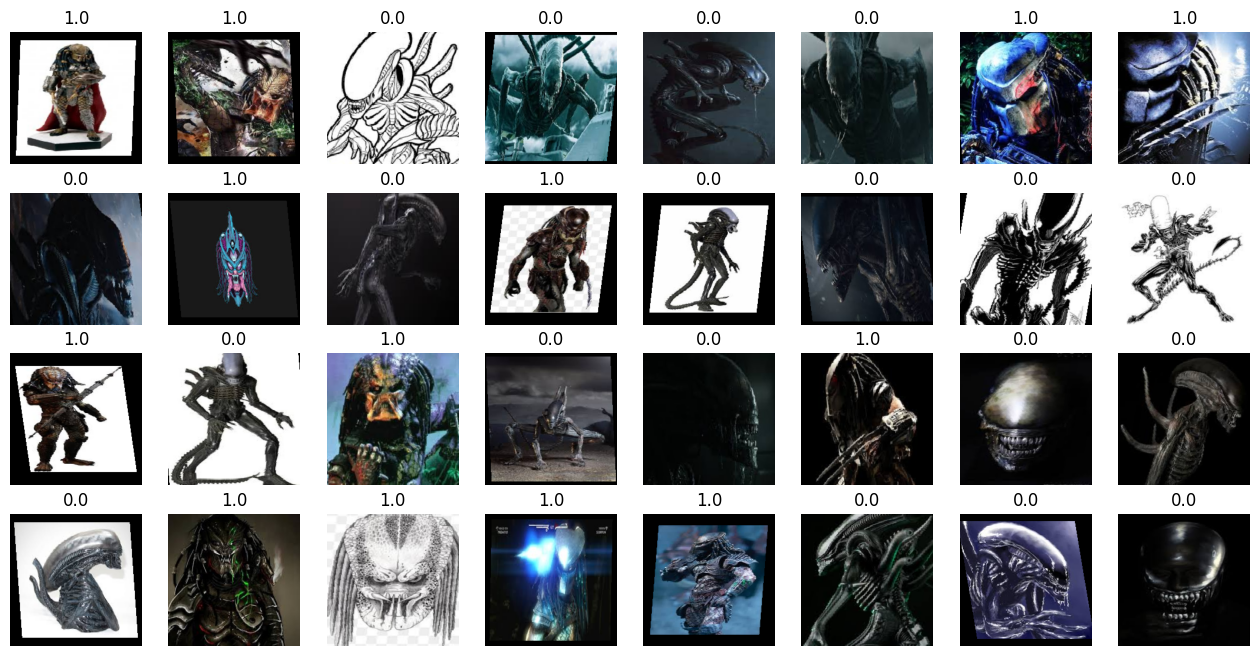

In [ ]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.permute(1, 2, 0)) # (3, 224, 224) -> (224, 224, 3)
    ax.set_title(label.item())
    ax.axis('off')

# 3. 전이 학습(Transfer Learning)
* 하나의 작업을 위해 훈련된 모델을 유사작업 수행 모델의 시작접으로 활용할 수 있는 딥러닝 접근법
* 신경망은 처음부터 새로 학습하는 것보다 전이 학습을 통해 업데이트하고 재학습하는 편이 더 빠르고 간편함
* 전이 학습은 여러 응용분야(검출, 영상인식, 음성인식, 검색분야, 자연어 분야)에서 많이 사용됨

![](https://miro.medium.com/max/1400/1*9GTEzcO8KxxrfutmtsPs3Q.png)

### 3-1. 전이학습의 고려할 점
* 크기 : 모델 크기는 배포할 위치와 방법에 따라 달라짐
* 속도 및 정확도: 하드웨어, 배치크기와

![](https://kr.mathworks.com/discovery/transfer-learning/_jcr_content/mainParsys/image.adapt.full.medium.jpg/1634621302937.jpg)

### 3-2. 사전 학습된 ResNet50 모델 사용하기

* [파이토치에서 제공하는 사전학습 모델들](https://pytorch.org/vision/stable/models.html)

![](https://i.stack.imgur.com/gI4zT.png)

# 4. 이미지넷(ImageNet)
* 이미지 데이터베이스
* 1000개의 클래스로 동물과 사물 이미지를 포함

![](https://i.imgur.com/5Rz5s8e.png)

In [ ]:
model = models.resnet50(weights='IMAGENET1K_V1').to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 5. Freeze Layers
* 특징을 뽑아내는 CNN의 앞쪽 컨볼루션 레이어들은 학습을 하지 않도록 설정
* 출력 부분의 레이어(fc)를 다시 설정하여 분류에 맞게 변경

In [ ]:
for param in model.parameters():
    param.requires_grad = False # 가져온 파라미터 (W,b)를 업데이트 하지 않음

In [ ]:
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# 학습
# optim: Adam
# lr: 0.001
# epochs: 10

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)
            loss = nn.BCELoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss:.4f} Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10 Loss: 0.5616 Accuracy: 71.20%
validation: Epoch    1/10 Loss: 0.3160 Accuracy: 86.61%
train     : Epoch    2/10 Loss: 0.2863 Accuracy: 87.64%
validation: Epoch    2/10 Loss: 0.2351 Accuracy: 92.41%
train     : Epoch    3/10 Loss: 0.2379 Accuracy: 90.72%
validation: Epoch    3/10 Loss: 0.2254 Accuracy: 91.07%
train     : Epoch    4/10 Loss: 0.1994 Accuracy: 92.77%
validation: Epoch    4/10 Loss: 0.2164 Accuracy: 90.63%
train     : Epoch    5/10 Loss: 0.2093 Accuracy: 90.48%
validation: Epoch    5/10 Loss: 0.2017 Accuracy: 91.07%
train     : Epoch    6/10 Loss: 0.2114 Accuracy: 91.99%
validation: Epoch    6/10 Loss: 0.2870 Accuracy: 88.84%
train     : Epoch    7/10 Loss: 0.1882 Accuracy: 92.21%
validation: Epoch    7/10 Loss: 0.2431 Accuracy: 90.63%
train     : Epoch    8/10 Loss: 0.2433 Accuracy: 89.51%
validation: Epoch    8/10 Loss: 0.2307 Accuracy: 90.18%
train     : Epoch    9/10 Loss: 0.1483 Accuracy: 94.05%
validation: Epoch    9/10 Loss: 0.2155 Accuracy:

In [ ]:
from PIL import Image

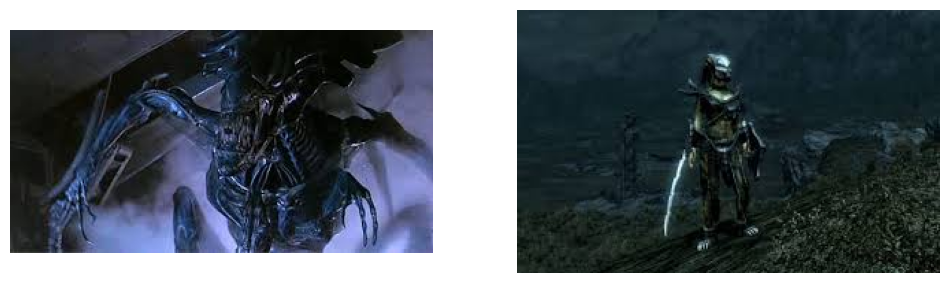

In [ ]:
img1 = Image.open('./data/validation/alien/22.jpg')
img2 = Image.open('./data/validation/predator/29.jpg')

fig,axes = plt.subplots(1,2,figsize=(12,6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [ ]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [ ]:
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [ ]:
y_pred = model(test_batch)
y_pred

tensor([[0.0330],
        [0.3734]], device='cuda:0', grad_fn=<SigmoidBackward0>)

(-0.5, 283.5, 176.5, -0.5)

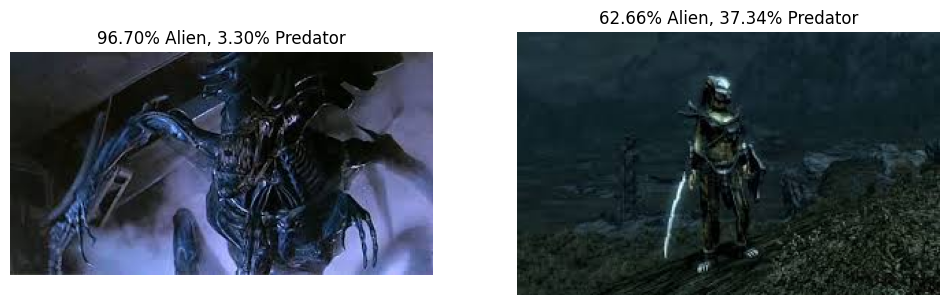

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title(f'{(1-y_pred[0, 0])*100:.2f}% Alien, {(y_pred[0, 0])*100:.2f}% Predator')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{(1-y_pred[1, 0])*100:.2f}% Alien, {(y_pred[1, 0])*100:.2f}% Predator')
axes[1].imshow(img2)
axes[1].axis('off')

# 99. 필기

1. 바이너리(이진분류) : 출력값은 1. 이 조건인지 아닌지의 값(1)이기 때문